In [3]:
import openmc
import matplotlib.pyplot as plt
import numpy as np

In [4]:
#Lupin materials

#lead casing
lead = openmc.Material(name='lead')
lead.add_element('Pb', 1, 'ao')
#aluminium shell
al = openmc.Material(name='aluminium')
al.add_element('Al', 1, 'ao')
#cadmium 
cadmium = openmc.Material(name='cadmium')
cadmium.add_element('Cd', 1, 'ao')
#BF3
bf3 = openmc.Material(name='bf3')
bf3.add_elements_from_formula('BF3')
#polyethylene
polyethylene = openmc.Material(name='polyethylene')
polyethylene.add_elements_from_formula('C2H4')
polyethylene.set_density('kg/m3',940)
mats = openmc.Materials([al, bf3, polyethylene])

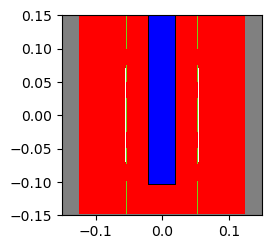

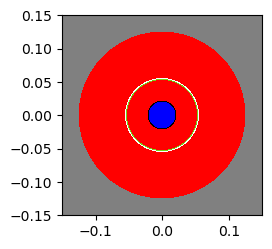

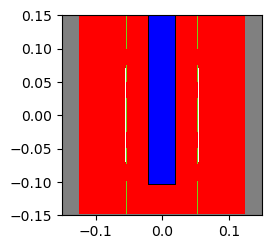

In [26]:
detector_radius = 0.02
shielding_thickness = 0.0015
inner_cylinder_radius = 0.054
cd_thickness = 0.0015
lead_thickness = 0.0015
outer_cylinder_radius = 0.125

detector_height = 0.0455
cylinder_height = 0.297
lead_height = 0.141
big_cd_height = 0.05
small_cd_height = 0.025
cd_gap = 0.02425
source_distance = 0.5

source_sphere = openmc.Sphere(r=source_distance)
outer_void = openmc.Sphere(r=source_distance + 0.01, boundary_type='vacuum')
inner_cylinder = openmc.ZCylinder(r=inner_cylinder_radius)
shielding = openmc.ZCylinder(r=detector_radius+shielding_thickness)
detector = openmc.ZCylinder(r=detector_radius)
cd_cylinder = openmc.ZCylinder(r=inner_cylinder_radius - cd_thickness)
lead_cylinder = openmc.ZCylinder(r=inner_cylinder_radius + lead_thickness)
outer_cylinder = openmc.ZCylinder(r=outer_cylinder_radius)

top_cylinder = openmc.ZPlane(z0=0.5*cylinder_height)
bottom_cylinder = openmc.ZPlane(z0=-0.5*cylinder_height)
bottom_detector = openmc.ZPlane(z0=-0.5*cylinder_height+detector_height)
bottom_shielding = openmc.ZPlane(z0=-0.5*cylinder_height+detector_height-shielding_thickness)
top_lead = openmc.ZPlane(z0=0.5*lead_height)
bottom_lead = openmc.ZPlane(z0=-0.5*lead_height)

bottom_cd_1 = openmc.ZPlane(z0=(0.5*cylinder_height) -big_cd_height)
top_cd_2 = openmc.ZPlane(z0=0.5*cylinder_height - big_cd_height - cd_gap)
bottom_cd_2 = openmc.ZPlane(z0=0.5*cylinder_height - big_cd_height -cd_gap - small_cd_height)
top_cd_3 = openmc.ZPlane(z0=0.5*cylinder_height - big_cd_height -(2*cd_gap) - small_cd_height)
bottom_cd_3 = openmc.ZPlane(-0.5*cylinder_height + big_cd_height + (2*cd_gap) + small_cd_height)
top_cd_4 = openmc.ZPlane(z0=-0.5*cylinder_height + big_cd_height + cd_gap + small_cd_height)
bottom_cd_4 = openmc.ZPlane(z0=-0.5*cylinder_height + big_cd_height + cd_gap)
top_cd_5 = openmc.ZPlane(z0=-0.5*cylinder_height + big_cd_height)

detector_region = -detector & -top_cylinder & + bottom_detector
shielding_region = (+detector & -shielding & -top_cylinder & +bottom_shielding) | (-detector & -bottom_detector & +bottom_shielding)

cd_inner = -inner_cylinder & +cd_cylinder

cd_1 = cd_inner & -top_cylinder & +bottom_cd_1
cd_2 = cd_inner & -top_cd_2 & +bottom_cd_2
cd_3 = cd_inner & -top_cd_3 & +bottom_cd_3
cd_4 = cd_inner & -top_cd_4 & +bottom_cd_4
cd_5 = cd_inner & -top_cd_5 & +bottom_cylinder

cd_region = cd_1 | cd_2 | cd_3 | cd_4 | cd_5
inner_poly_region = ((-inner_cylinder & -top_cylinder & +bottom_cylinder & +shielding) & ~cd_region) | (-shielding & -bottom_shielding & +bottom_cylinder)
lead_region = -lead_cylinder & +bottom_lead & -top_lead & + inner_cylinder

outer_poly_region = (-outer_cylinder & +lead_cylinder & -top_cylinder & +bottom_cylinder) | (-lead_cylinder & +inner_cylinder & -top_cylinder & +top_lead) |(-lead_cylinder & +inner_cylinder & -bottom_lead & +bottom_cylinder)

sphere_region = (-source_sphere & +outer_cylinder) | (-outer_cylinder & -source_sphere &+top_cylinder) | (-outer_cylinder & -source_sphere & -bottom_cylinder)


detector_cell = openmc.Cell(region=detector_region, fill =bf3)
shielding_cell = openmc.Cell(region=shielding_region, fill = al)
poly_cell = openmc.Cell(region=(inner_poly_region | outer_poly_region), fill = polyethylene)
cd_cell = openmc.Cell(region=cd_region, fill =cadmium)
lead_cell = openmc.Cell(region=lead_region, fill=lead)
sphere_cell = openmc.Cell(region=sphere_region)
outer_void_cell = openmc.Cell(region= +source_sphere & -outer_void)

universe = openmc.Universe(cells=[sphere_cell, shielding_cell, detector_cell,poly_cell, outer_void_cell, cd_cell])
geom = openmc.Geometry(universe)
x,y = 0.3,0.3
colour_assignment = {sphere_cell: 'grey', shielding_cell: 'black', detector_cell: 'blue', poly_cell: 'red', shielding_cell: 'black'}
plt.show(universe.plot(width=(x, y), basis='xz', colors=colour_assignment))
plt.show(universe.plot(width=(x, y), basis='xy', colors=colour_assignment))
plt.show(universe.plot(width=(x, y), basis='yz', colors=colour_assignment))

In [12]:
import openmc
import openmc_plotter



In [13]:
#settings
import openmc_source_plotter as osp

sett = openmc.Settings()
sett.batches = 5
sett.inactive = 0
sett.particles = 10000
sett.run_mode = 'fixed source'

#source
sphere_source = openmc.Source()
sphere_source.angle = openmc.stats.Isotropic()
sphere_source.energy = openmc.stats.Discrete([14e6], [1])
sphere_source.space = openmc.stats.spherical_uniform(r_outer=source_distance, r_inner=source_distance)
sphere_source.particle = 'neutron'
sett.source = sphere_source

#plot = sphere_source.plot_source_position(n_samples=5000)
#plot.show()

In [14]:
#tallies
tallies = openmc.Tallies()

energy_filter = openmc.EnergyFilter(np.linspace(0,15e6,200))
neutron_filter = openmc.ParticleFilter(['neutron'])
detector_cell_filter = openmc.CellFilter(detector_cell)

detector_tally = openmc.Tally()
detector_tally.filters = [energy_filter, neutron_filter, detector_cell_filter]
detector_tally.scores = ['flux']
tallies.append(detector_tally)

In [15]:
# combine all the required parts to make a model
model = openmc.model.Model(geom, mats, sett, tallies)

# remove old files and runs OpenMC
!rm *.h5
results_filename = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [23]:
sp = openmc.StatePoint(results_filename)
tally  = sp.get_tally(name='detector_tally')

LookupError: Unable to get Tally

In [20]:
#print geometry
vox_plot = openmc.Plot()
vox_plot.type = 'voxel'
vox_plot.width = (0.1,0.1,0.6)
vox_plot.pixels = (500,500,500)
vox_plot.filename = 'plot_lupin_geom'
vox_plot.color_by = 'material'
vox_plot.colors = {bf3: 'blue', al: 'black', polyethylene: 'green'}
plots = openmc.Plots([vox_plot])
plots.export_to_xml()
openmc.plot_geometry()

import os
os.system('openmc-voxel-to-vtk plot_lupin_geom.h5 -o plot_lupin_geom.vti')

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

0